# Highlights of the scikit-learn release 0.22

## Fetching dataframe from OpenML

In [3]:
from sklearn.datasets import fetch_openml

You can use the attribute `as_frame` in complement of `return_X_y=True` to get directly the data as a dataframe and a serie.

In [4]:
df, y = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
df = df.drop(columns=['fnlwgt', 'education-num'])

In [5]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


## New histogram-based gradient boosting

In [10]:
df, y = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True)
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
pclass       1309 non-null float64
name         1309 non-null object
sex          1309 non-null category
age          1046 non-null float64
sibsp        1309 non-null float64
parch        1309 non-null float64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null category
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: category(2), float64(6), object(5)
memory usage: 115.4+ KB


In [12]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
clf = RandomForestClassifier().fit(df[['fare']], y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [15]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [16]:
clf = HistGradientBoostingClassifier().fit(df[['fare']], y)

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['age', 'fare']
numeric_transformer = FunctionTransformer()

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', HistGradientBoostingClassifier())])

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df, y, random_state=42
)

In [25]:
clf.fit(X_train, y_train).score(X_test, y_test)

0.7987804878048781

## Smoother integration of Dataframe in partial dependece plot

In [39]:
%matplotlib inline

In [42]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target

y -= y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                    random_state=0)

In [44]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

est = make_pipeline(QuantileTransformer(),
                    MLPRegressor(hidden_layer_sizes=(50, 50),
                                 learning_rate_init=0.01,
                                 early_stopping=True))
est.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('quantiletransformer',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('mlpregressor',
                 MLPRegressor(activation='relu', alpha=0.0001,
                              batch_size='auto', beta_1=0.9, beta_2=0.999,
                              early_stopping=True, epsilon=1e-08,
                              hidden_layer_sizes=(50, 50),
                              learning_rate='constant', learning_rate_init=0.01,
                              max_fun=15000, max_iter=200, momentum=0.9,
                              n_iter_no_change=10, nesterovs_momentum=True,
                              power_t=0.5, random_state=None, shuffle=True,
                              solver='adam', tol=0.0001,
   

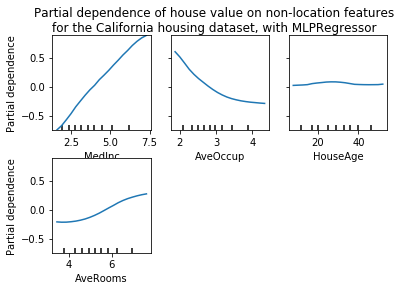

In [46]:
import matplotlib.pyplot as plt

features = ['MedInc', 'AveOccup', 'HouseAge', 'AveRooms']
plot_partial_dependence(est, X_train, features,
                        n_jobs=-1, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the California housing dataset, with MLPRegressor')
fig.subplots_adjust(hspace=0.3)

## New Imputers and option

In [47]:
df, y = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True)
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
pclass       1309 non-null float64
name         1309 non-null object
sex          1309 non-null category
age          1046 non-null float64
sibsp        1309 non-null float64
parch        1309 non-null float64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null category
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: category(2), float64(6), object(5)
memory usage: 115.4+ KB


In [51]:
df[['boat']]

,boat
0,2
1,11
2,None
3,None
4,None
...,...
1304,None
1305,None
1306,None
1307,None


In [54]:
from sklearn.impute import SimpleImputer

SimpleImputer(
    missing_values=None, strategy='constant',
    fill_value='0', add_indicator=True
).fit_transform(df[['boat']])

array([['2', False],
       ['11', False],
       ['0', True],
       ...,
       ['0', True],
       ['0', True],
       ['0', True]], dtype=object)

In [55]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

In [56]:
calhousing = fetch_california_housing()

X = pd.DataFrame(calhousing.data, columns=calhousing.feature_names)
y = pd.Series(calhousing.target, name='house_value')

In [59]:
import numpy as np
rng = np.random.RandomState(42)

density = 4  # one in 10 values will be NaN

mask = rng.randint(density, size=X.shape) == 0
X_na = X.copy()
X_na.values[mask] = np.nan
X_na.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,NaN,1.023810,322.0,2.555556,NaN,NaN
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,NaN
2,7.2574,52.0,8.288136,1.073446,496.0,NaN,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,NaN,NaN
4,3.8462,52.0,6.281853,NaN,565.0,NaN,NaN,-122.25


In [60]:
X_train_na, X_test_na, y_train_na, y_test_na = train_test_split(
    X_na[y<4.9], y[y<4.9], test_size=1000, random_state=0)

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

model = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy="mean", add_indicator=True),
    LinearRegression()
)
model.fit(X_train_na, y_train_na).score(X_test_na, y_test_na)

0.3551087631458031

In [70]:
model = make_pipeline(
    StandardScaler(),
    IterativeImputer(add_indicator=True),
    LinearRegression()
)
model.fit(X_train_na, y_train_na).score(X_test_na, y_test_na)

/home/glemaitre/Documents/packages/scikit-learn/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


0.4526488994124177

In [71]:
model = make_pipeline(
    StandardScaler(),
    KNNImputer(add_indicator=True),
    LinearRegression()
)
model.fit(X_train_na, y_train_na).score(X_test_na, y_test_na)

MemoryError: Unable to allocate array with shape (311408488,) and data type float64

## Stacking estimators

In [ ]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)

In [75]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

estimators = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Lasso', LassoCV()),
    ('Gradient Boosting', HistGradientBoostingRegressor(random_state=0))
]
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV()
)

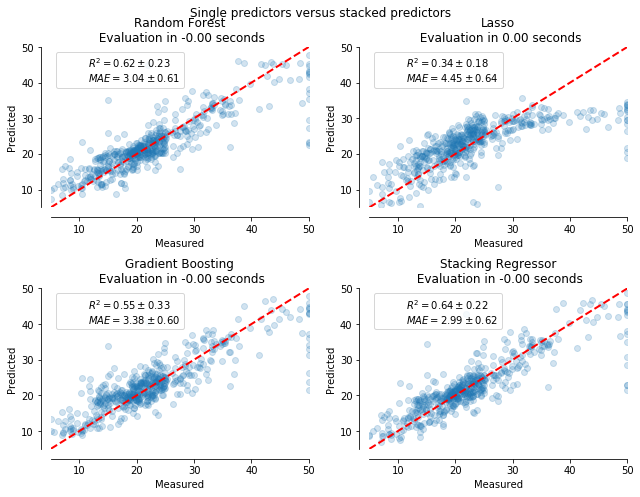

In [76]:
import time
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_validate, cross_val_predict

X, y = load_boston(return_X_y=True)

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    score = cross_validate(est, X, y,
                           scoring=['r2', 'neg_mean_absolute_error'],
                           n_jobs=-1, verbose=0)
    elapsed_time = time.time() - time.time()

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    plot_regression_results(
        ax, y, y_pred,
        name,
        (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$')
        .format(np.mean(score['test_r2']),
                np.std(score['test_r2']),
                -np.mean(score['test_neg_mean_absolute_error']),
                np.std(score['test_neg_mean_absolute_error'])),
        elapsed_time)

plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Feature importance computed via permuation test

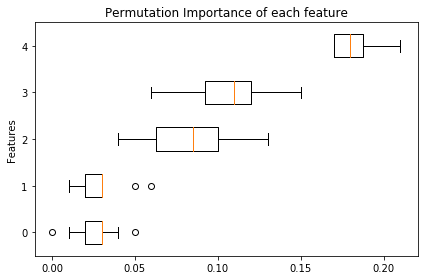

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification

X, y = make_classification(random_state=0, n_features=5, n_informative=3)
rf = RandomForestClassifier(random_state=0).fit(X, y)
result = permutation_importance(rf, X, y, n_repeats=10, random_state=0,
                                n_jobs=-1)

fig, ax = plt.subplots()
sorted_idx = result.importances_mean.argsort()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=range(X.shape[1]))
ax.set_title("Permutation Importance of each feature")
ax.set_ylabel("Features")
fig.tight_layout()
plt.show()

## Tree pruning

In [79]:
rf = RandomForestClassifier(random_state=0, ccp_alpha=0).fit(X, y)
print("Average number of nodes without pruning {:.1f}".format(
    np.mean([e.tree_.node_count for e in rf.estimators_])))

rf = RandomForestClassifier(random_state=0, ccp_alpha=0.05).fit(X, y)
print("Average number of nodes with pruning {:.1f}".format(
    np.mean([e.tree_.node_count for e in rf.estimators_])))

Average number of nodes without pruning 24.9
Average number of nodes with pruning 8.3
